Episode 500/50000, Success Rate: 0.090, Epsilon: 0.779
Episode 1000/50000, Success Rate: 0.030, Epsilon: 0.606
Episode 1500/50000, Success Rate: 0.120, Epsilon: 0.472
Episode 2000/50000, Success Rate: 0.080, Epsilon: 0.368
Episode 2500/50000, Success Rate: 0.150, Epsilon: 0.286
Episode 3000/50000, Success Rate: 0.210, Epsilon: 0.223
Episode 3500/50000, Success Rate: 0.230, Epsilon: 0.174
Episode 4000/50000, Success Rate: 0.320, Epsilon: 0.135
Episode 4500/50000, Success Rate: 0.300, Epsilon: 0.105
Episode 5000/50000, Success Rate: 0.360, Epsilon: 0.082
Episode 5500/50000, Success Rate: 0.420, Epsilon: 0.064
Episode 6000/50000, Success Rate: 0.480, Epsilon: 0.050
Episode 6500/50000, Success Rate: 0.510, Epsilon: 0.039
Episode 7000/50000, Success Rate: 0.420, Epsilon: 0.030
Episode 7500/50000, Success Rate: 0.520, Epsilon: 0.023
Episode 8000/50000, Success Rate: 0.540, Epsilon: 0.018
Episode 8500/50000, Success Rate: 0.680, Epsilon: 0.014
Episode 9000/50000, Success Rate: 0.730, Epsilon:

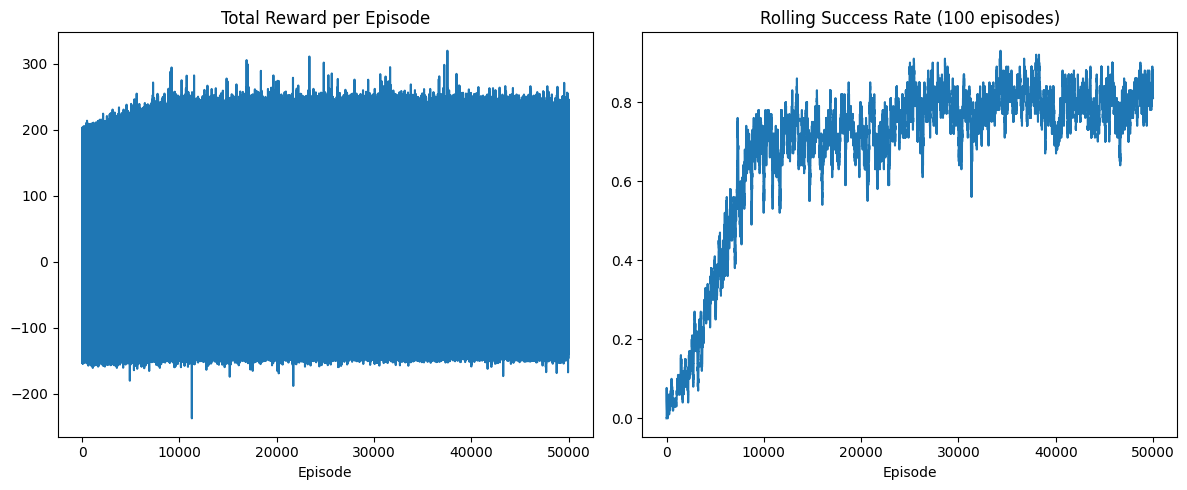

In [35]:
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import math

# Maze symbols
WALL = '#'
EMPTY = '.'

# Sample maze (15x10)
sample_maze = [
    "###############",
    "#.............#",
    "#.#.#####.#.#.#",
    "#.#.....#.#.#.#",
    "#.#..##.#.#.#.#",
    "#.#.....#.#.#.#",
    "#.#.###.#.#.#.#",
    "#.#.....#.#.#.#",
    "#.............#",
    "###############"
]

class MazeEnv:
    def __init__(self, maze):
        self.maze = maze
        self.width = len(maze[0])
        self.height = len(maze)
        self.walls = set()
        self.cup_pos = None
        self.harry_pos = None
        self.death_eater_pos = None
        self.visited_states = {}
        self.episode_count = 0
        self.add_walls()

    def add_walls(self):
        for y, row in enumerate(self.maze):
            for x, char in enumerate(row):
                if char == WALL:
                    self.walls.add((x, y))

    def reset(self):
        self.visited_states = {}
        empty_cells = [(x, y) for y in range(self.height) for x in range(self.width)
                      if (x, y) not in self.walls]
        
        # Fixed cup position for first 500 episodes to help model learn:
        if self.episode_count < 500:
            if not hasattr(self, 'fixed_cup_pos'):
                center_x, center_y = self.width//2, self.height//2
                potential = [(x,y) for x,y in empty_cells 
                           if abs(x-center_x)+abs(y-center_y) < 5]
                self.fixed_cup_pos = random.choice(potential)
            self.cup_pos = self.fixed_cup_pos
        else:
            self.cup_pos = random.choice(empty_cells)
        
        empty_cells.remove(self.cup_pos)
        self.harry_pos = random.choice(empty_cells)
        empty_cells.remove(self.harry_pos)
        
        self.death_eater_pos = random.choice(empty_cells)
        
        return self.get_state()

    def get_state(self):
        return (self.harry_pos, self.death_eater_pos, self.cup_pos)

    def is_valid_pos(self, pos):
        x, y = pos
        return 0 <= x < self.width and 0 <= y < self.height and pos not in self.walls

    def move_agent(self, pos, action):
        x, y = pos
        if action == 0:  # Up
            new_pos = (x, y-1)
        elif action == 1:  # Down
            new_pos = (x, y+1)
        elif action == 2:  # Left
            new_pos = (x-1, y)
        elif action == 3:  # Right
            new_pos = (x+1, y)
        else:
            new_pos = pos
        return new_pos if self.is_valid_pos(new_pos) else pos

    def death_eater_move(self):
        start = self.death_eater_pos
        goal = self.harry_pos
        if start == goal:
            return start
        
        queue = deque([start])
        visited = {start: None}
        while queue:
            current = queue.popleft()
            if current == goal:
                break
            for action in range(4):
                neighbor = self.move_agent(current, action)
                if neighbor not in visited:
                    visited[neighbor] = current
                    queue.append(neighbor)
        3
        if goal not in visited:
            return self.death_eater_pos
        
        step = goal
        while visited[step] != start:
            step = visited[step]
        return step

def m_distance(pos1, pos2):
    return abs(pos1[0]-pos2[0]) + abs(pos1[1]-pos2[1])

class QLearningAgent:
    def __init__(self, env, learning_rate=0.05, discount_factor=0.99, 
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = {}
        self.replay_buffer = deque(maxlen=2000)
        
    def get_q(self, state, action):
        hx, hy = state[0]
        dx, dy = state[1]
        cx, cy = state[2]
        
        rel_x = hx - cx
        rel_y = hy - cy
        de_x = hx - dx
        de_y = hy - dy
        
        cup_dir = (1 if rel_x>0 else (-1 if rel_x<0 else 0), 
                   1 if rel_y>0 else (-1 if rel_y<0 else 0))
        de_dir = (1 if de_x>0 else (-1 if de_x<0 else 0), 
                  1 if de_y>0 else (-1 if de_y<0 else 0))
        
        return self.q_table.get((hx, hy, de_dir[0], de_dir[1], cup_dir[0], cup_dir[1], action), 0.0)

    def set_q(self, state, action, value):
        hx, hy = state[0]
        dx, dy = state[1]
        cx, cy = state[2]
        
        rel_x = hx - cx
        rel_y = hy - cy
        de_x = hx - dx
        de_y = hy - dy
        
        cup_dir = (1 if rel_x>0 else (-1 if rel_x<0 else 0), 
                   1 if rel_y>0 else (-1 if rel_y<0 else 0))
        de_dir = (1 if de_x>0 else (-1 if de_x<0 else 0), 
                  1 if de_y>0 else (-1 if de_y<0 else 0))
        
        self.q_table[(hx, hy, de_dir[0], de_dir[1], cup_dir[0], cup_dir[1], action)] = value

    def choose_action(self, state):
        if np.random.rand() < 0.01:  # 1% random exploration
            return np.random.choice(4)
        if np.random.rand() < self.epsilon:
            return np.random.choice(4)
        else:
            q_values = [self.get_q(state, a) for a in range(4)]
            max_q = max(q_values)
            return np.random.choice([a for a, q in enumerate(q_values) if q == max_q])

    def learn(self, state, action, reward, next_state, done):
        # Standard Q-learning update
        current_q = self.get_q(state, action)
        max_next_q = max([self.get_q(next_state, a) for a in range(4)]) if not done else 0
        new_q = current_q + self.lr * (reward + self.gamma * max_next_q - current_q)
        self.set_q(state, action, new_q)
        
        # Store experience
        self.replay_buffer.append((state, action, reward, next_state, done))
        
        # Experience replay
        if len(self.replay_buffer) >= 64:
            self.experience_replay()

    def experience_replay(self):
        mini_batch = random.sample(self.replay_buffer, 32)
        for state, action, reward, next_state, done in mini_batch:
            current_q = self.get_q(state, action)
            max_next_q = max([self.get_q(next_state, a) for a in range(4)]) if not done else 0
            new_q = current_q + self.lr * 0.5 * (reward + self.gamma * max_next_q - current_q)
            self.set_q(state, action, new_q)

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save_q_table(self, filename):
        import pickle
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

def get_reward(env, harry_pos, cup_pos, caught, prev_harry_pos=None):
    if harry_pos == cup_pos:
        return 200
    elif caught:
        return -150
    
    reward = -1
    
    # Revisit penalty
    if harry_pos in env.visited_states:
        reward -= 0.5
    env.visited_states[harry_pos] = env.visited_states.get(harry_pos, 0) + 1
    
    # Proximity reward
    dist_to_cup = m_distance(harry_pos, cup_pos)
    max_dist = env.width + env.height
    reward += 2 * (1 - dist_to_cup / max_dist)
    
    # Distance from DE reward
    if prev_harry_pos:
        prev_dist = m_distance(prev_harry_pos, env.death_eater_pos)
        curr_dist = m_distance(harry_pos, env.death_eater_pos)
        if curr_dist > prev_dist:
            reward += 0.5
            
    return reward

def step(env, action):
    prev_pos = env.harry_pos
    env.harry_pos = env.move_agent(env.harry_pos, action)
    env.death_eater_pos = env.death_eater_move()
    
    caught = (env.harry_pos == env.death_eater_pos)
    success = (env.harry_pos == env.cup_pos)
    reward = get_reward(env, env.harry_pos, env.cup_pos, caught, prev_pos)
    
    return env.get_state(), reward, (caught or success)

# Training setup
env = MazeEnv(sample_maze)
agent = QLearningAgent(env)

MAX_episodes = 50000
success_streak = 0
success_threshold = 10
rewards = []
success_rates = []
successes = []

flag=0
first_instance=0

# ////////////////////////////////////////////////////////////////////////////////
# MAIN TRAINING LOOP-

for episode in range(MAX_episodes):
    env.episode_count = episode
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    max_steps = 200
    
    while not done and steps < max_steps:
        action = agent.choose_action(state)
        next_state, reward, done = step(env, action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        steps += 1
    
    # Timeout penalty
    if steps >= max_steps:
        total_reward -= 50
        success = False
    else:
        success = (env.harry_pos == env.cup_pos)
    
    successes.append(1 if success else 0)
    rewards.append(total_reward)
    
    # Update success streak
    success_streak = success_streak + 1 if success else 0
    
    # Rolling success rate
    window = 100
    if episode >= window:
        success_rate = sum(successes[-window:])/window
    else:
        success_rate = sum(successes)/(episode+1)
    success_rates.append(success_rate)
    
    agent.update_epsilon()
    
    # Progress tracking
    if (episode+1) % 500 == 0:
        print(f"Episode {episode+1}/{MAX_episodes}, Success Rate: {success_rate:.3f}, Epsilon: {agent.epsilon:.3f}")
    if (flag==0 and success_streak >= success_threshold):
        flag=1
        first_instance = episode
        #print("\n\n", latest_q_table)
        #break
    
# END OF LOOP
# ////////////////////////////////////////////////////////////////////////////////

agent.save_q_table('q_table.pkl')  # Saving trained weights of the q_table

print(f"\nAchieved {success_threshold} consecutive successes at episode {first_instance}")
latest_q_table = agent.q_table
print(f"Q-table entries: {len(agent.q_table)}")
trained_env = env

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')

plt.subplot(1,2,2)
plt.plot(success_rates)
plt.title('Rolling Success Rate (100 episodes)')
plt.xlabel('Episode')
plt.tight_layout()
plt.show()


# Rendering in Pygame:

### need not run this here; see TrainedModel.ipynb

In [ ]:
import pygame
import time

CELL_SIZE = 40
MARGIN = 2
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)
GOLD = (255, 215, 0)
BROWN = (139, 69, 19)
GREEN = (0, 255, 0)
INFO_HEIGHT = 100

pygame.init()
pygame.font.init()

def render_maze(self, episode=0, total_reward=0):

    self.screen_width = self.width * (CELL_SIZE + MARGIN) + MARGIN
    self.screen_height = self.height * (CELL_SIZE + MARGIN) + MARGIN + INFO_HEIGHT
    self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
    pygame.display.set_caption("The Goblet of Fire - Triwizard Maze")
    self.font = pygame.font.SysFont('Arial', 16)
    
    self.screen.fill(BLACK)
    
    #banjar zameen
    for y in range(self.height):
        for x in range(self.width):
            rect = pygame.Rect(
                x * (CELL_SIZE + MARGIN) + MARGIN,
                y * (CELL_SIZE + MARGIN) + MARGIN,
                CELL_SIZE,
                CELL_SIZE
            )
            if (x, y) in self.walls:
                pygame.draw.rect(self.screen, BROWN, rect)
            else:
                pygame.draw.rect(self.screen, WHITE, rect)
    
    #Cup
    if self.cup_pos:
        x, y = self.cup_pos
        cup_rect = pygame.Rect(
            x * (CELL_SIZE + MARGIN) + MARGIN,
            y * (CELL_SIZE + MARGIN) + MARGIN,
            CELL_SIZE,
            CELL_SIZE
        )
        pygame.draw.rect(self.screen, GOLD, cup_rect)
    
    #Harry
    if self.harry_pos:
        x, y = self.harry_pos
        harry_rect = pygame.Rect(
            x * (CELL_SIZE + MARGIN) + MARGIN,
            y * (CELL_SIZE + MARGIN) + MARGIN,
            CELL_SIZE,
            CELL_SIZE
        )
        pygame.draw.rect(self.screen, BLUE, harry_rect)
        # Drawing (H)
        pygame.draw.line(self.screen, WHITE, 
            (x * (CELL_SIZE + MARGIN) + MARGIN + 10, y * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE//2),
            (x * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE - 10, y * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE//2), 2)
        pygame.draw.line(self.screen, WHITE,
            (x * (CELL_SIZE + MARGIN) + MARGIN + 10, y * (CELL_SIZE + MARGIN) + MARGIN + 10),
            (x * (CELL_SIZE + MARGIN) + MARGIN + 10, y * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE - 10), 2)
        pygame.draw.line(self.screen, WHITE,
            (x * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE - 10, y * (CELL_SIZE + MARGIN) + MARGIN + 10),
            (x * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE - 10, y * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE - 10), 2)
    
    #Death Eater
    if self.death_eater_pos:
        x, y = self.death_eater_pos
        de_rect = pygame.Rect(
            x * (CELL_SIZE + MARGIN) + MARGIN,
            y * (CELL_SIZE + MARGIN) + MARGIN,
            CELL_SIZE,
            CELL_SIZE
        )
        pygame.draw.rect(self.screen, RED, de_rect)
        center_x = x * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE//2
        center_y = y * (CELL_SIZE + MARGIN) + MARGIN + CELL_SIZE//2
        radius = CELL_SIZE//3
        pygame.draw.circle(self.screen, BLACK, (center_x, center_y), radius, 2)
    
    # neeche ka info panel
    info_surface = pygame.Surface((self.screen_width, INFO_HEIGHT))
    info_surface.fill((200, 200, 200))  # Light gray
    episode_text = self.font.render(f"Episode: {episode}", True, BLACK)
    reward_text = self.font.render(f"Total Reward: {total_reward}", True, BLACK)
    instruction_text = self.font.render("Press SPACE for next episode, ESC to quit", True, BLACK)
    controls_text = self.font.render("S: Step | R: Run episode | F: Toggle speed", True, BLACK)
    
    info_surface.blit(episode_text, (10, 10))
    info_surface.blit(reward_text, (10, 30))
    info_surface.blit(instruction_text, (10, 50))
    info_surface.blit(controls_text, (10, 70))
    
    self.screen.blit(info_surface, (0, self.height * (CELL_SIZE + MARGIN) + MARGIN))
    #Updating display-
    pygame.display.flip()

MazeEnv.render = render_maze

def run_game_visualization(agent, env):
    running = True
    episode = 0
    total_reward = 0
    state = env.reset()
    done = False
    auto_run = False
    step_mode = False
    delay = 0.2  #between steps
    
    env.render(episode, total_reward)
    
    clock = pygame.time.Clock()
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    running = False
                elif event.key == pygame.K_SPACE:
                    # Reset for new episode
                    state = env.reset()
                    total_reward = 0
                    done = False
                    episode += 1
                    env.render(episode, total_reward)
                    auto_run = False
                elif event.key == pygame.K_s:
                    # Step mode - take one step
                    if not done:
                        action = agent.choose_action(state)
                        next_state, reward, done = step(env, action)
                        state = next_state
                        total_reward += reward
                        env.render(episode, total_reward)
                elif event.key == pygame.K_r:
                    # Toggle auto run mode
                    auto_run = not auto_run
                elif event.key == pygame.K_f:
                    # Toggle speed
                    if delay > 0.05:
                        delay /= 2
                    else:
                        delay = 0.2
        
        # If in auto run mode, take steps automatically
        if auto_run and not done:
            action = agent.choose_action(state)
            next_state, reward, done = step(env, action)
            state = next_state
            total_reward += reward
            
            # Render the current state
            env.render(episode, total_reward)
            
            if done:
                if reward == 100:
                    outcome = "Harry found the Cup!"
                else:
                    outcome = "Harry was caught by the Death Eater!"
                print(f"Episode {episode} ended: {outcome} | Total Reward: {total_reward}")
                auto_run = False
            
            # Add a delay to visualize movements
            time.sleep(delay)
        
        # Control the frame rate
        clock.tick(60)
    
    pygame.quit()

# Use this function to run the visualization with the trained agent
def visualize_trained_agent():
    global trained_env
    trained_env.episode_count = 1000
    run_game_visualization(agent, trained_env)

if __name__ == "__main__":
    # This will use the agent from the training code
    visualize_trained_agent()


Episode 0 ended: Harry was caught by the Death Eater! | Total Reward: 209.24
Episode 1 ended: Harry was caught by the Death Eater! | Total Reward: 210.2
Episode 3 ended: Harry was caught by the Death Eater! | Total Reward: 207.1
Episode 5 ended: Harry was caught by the Death Eater! | Total Reward: 205.98
Episode 6 ended: Harry was caught by the Death Eater! | Total Reward: -123.88000000000001
Episode 7 ended: Harry was caught by the Death Eater! | Total Reward: -148.82
Episode 8 ended: Harry was caught by the Death Eater! | Total Reward: 210.3
Episode 9 ended: Harry was caught by the Death Eater! | Total Reward: 209.82
Episode 10 ended: Harry was caught by the Death Eater! | Total Reward: -128.70000000000002
Episode 11 ended: Harry was caught by the Death Eater! | Total Reward: -132.02
